# **Brief description of the problem and data**

This Kaggle competition is about classifying texts taken from Twitter using Natural Language Processing (NLP) to classify which are about real disasters and which are not. 

The complexity of the task is demonstrated using the sample Tweet provided by the competition: "LOOK AT THE NIGHT SKY LAST NIGHT IT WAS ABLAZE" where the author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away but it is less clear to a machine that it is not referencing a real disaster.

The dataset consists of 10,000 tweets that were hand classified.

# **Load Libraries**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import random
#import re
#from collections import defaultdict
import wordcloud
#from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [69]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [25]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_data['target'].value_counts().to_frame()

,target
0,4342
1,3271


Text(0, 0.5, 'Count')

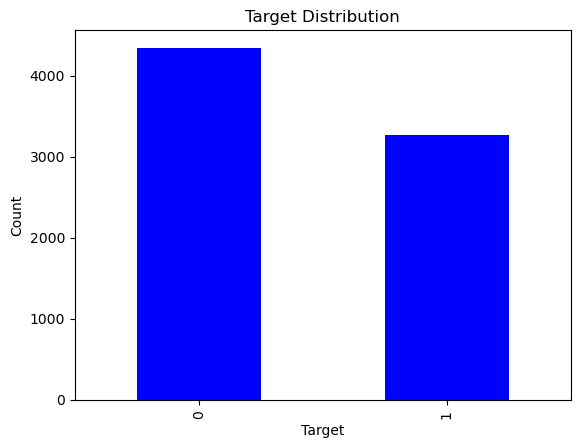

In [20]:
train_data.groupby(['target'])['target'].count().plot(kind='bar', color = 'blue', title='Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

Text(0.5, 0, 'Count')

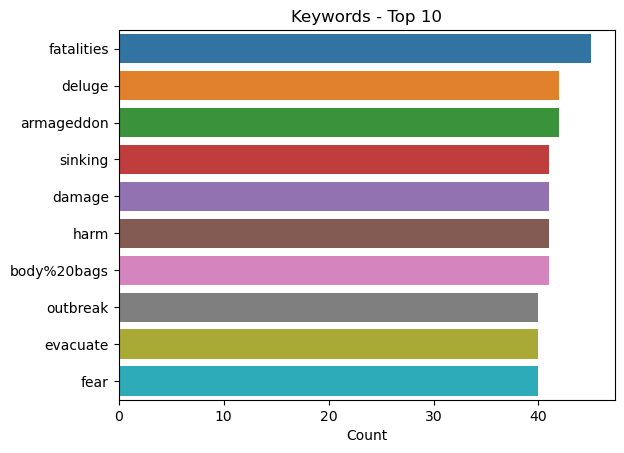

In [56]:
val=train_data['keyword'].value_counts()[:10]
sns.barplot(x=val,y=val.index)
plt.title("Keywords - Top 10")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

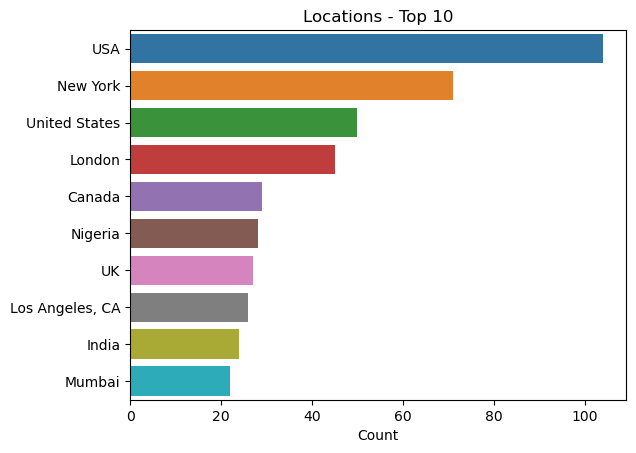

In [41]:
val=train_data['location'].value_counts()[:10]
sns.barplot(x=val,y=val.index)
plt.title("Locations - Top 10")
plt.xlabel("Count")

Text(0.5, 0, '# Words')

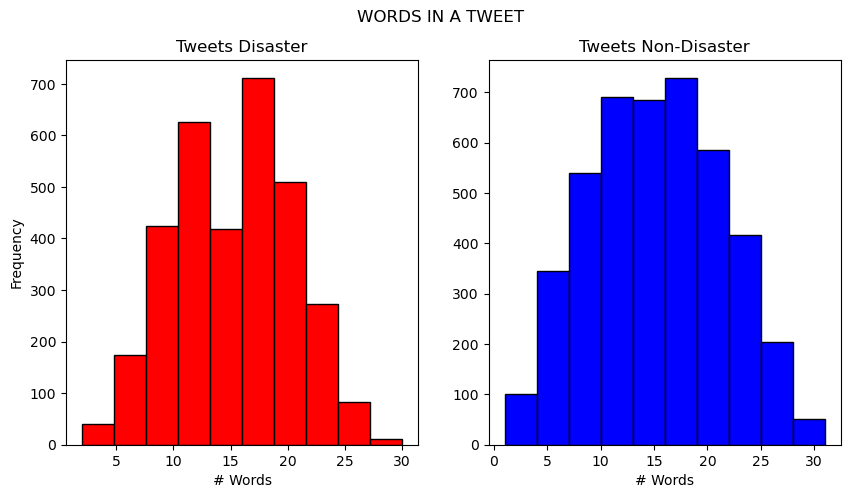

In [19]:
text_length = train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('WORDS IN A TWEET')
ax1.hist(text_length, color='red', edgecolor='black')
ax1.set_title('Tweets Disaster')
ax1.set_xlabel('# Words')
ax1.set_ylabel('Frequency')
text_length = train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_length,color='blue', edgecolor='black')
ax2.set_title('Tweets Non-Disaster')
ax2.set_xlabel('# Words')

Text(0.5, 1.0, 'Negative')

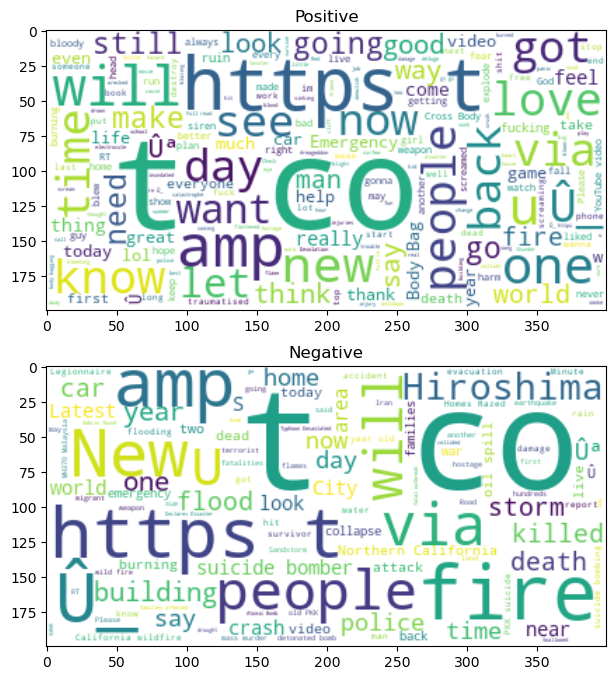

In [26]:
positive_cases = "".join(train_data[train_data['target'] == 0]['text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

In [62]:
# seed = 777
# os.environ['PYTHONHASHSEED']=str(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# print('done')

done


In [70]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 letters
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

#def strip_all_entities(x):
#    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [71]:
train_data['clean_text'] = train_data['text'].apply(lambda x: x.lower())
#train_data['text2'] = train_data['text2'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
train_data['clean_text'] = train_data['clean_text'].apply(remove_less_than)
train_data['clean_text'] = train_data['clean_text'].apply(remove_non_alphabet)
train_data['clean_text'] = train_data['clean_text'].apply(remove_stopwords)
train_data['clean_text'] = train_data['clean_text'].apply(remove_punctuation)
#train_data['text2'] = train_data['text2'].apply(spell_check)
print('done')

done


In [72]:
train_data.head(5)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked notified evacuation shelter pl...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,sent photo ruby smoke pours school


Text(0.5, 1.0, 'Negative')

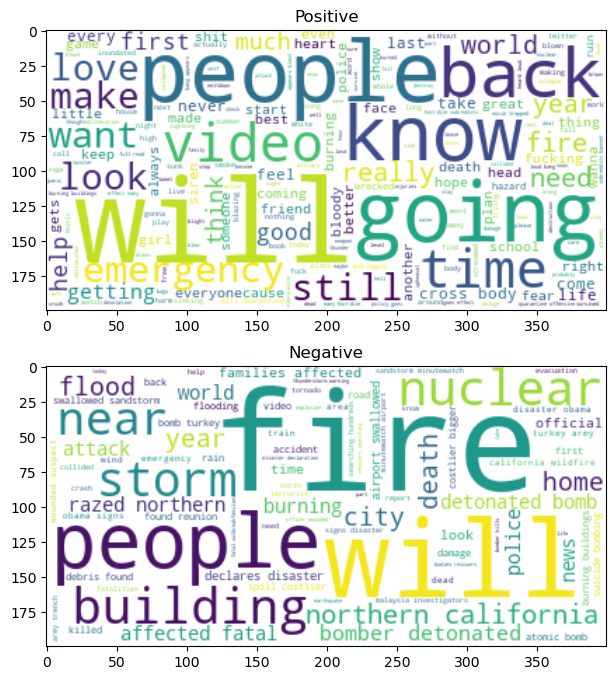

In [74]:
positive_cases = "".join(train_data[train_data['target'] == 0]['clean_text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['clean_text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

# **Build Model**

In [87]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
x = tokenizer.texts_to_sequences(train_data['clean_text'].values)
x = pad_sequences(x)
x.shape

(7613, 16)

In [88]:
y = train_data['target']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 777)

In [ ]:
#XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.
# reference: https://www.tensorflow.org/xla
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [ ]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
y_pred = model.predict(X_test).round()
y_pred

In [ ]:
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

In [ ]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

In [ ]:
conm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [ ]:
test_data.head().style.background_gradient(cmap='coolwarm')

In [ ]:
test_data['clean_text'] = test_data['text'].apply(lambda x: x.lower())
test_data['clean_text'] = test_data['clean_text'].apply(remove_less_than)
test_data['clean_text'] = test_data['clean_text'].apply(remove_non_alphabet)
test_data['clean_text'] = test_data['clean_text'].apply(remove_stopwords)
test_data['clean_text'] = test_data['clean_text'].apply(remove_punctuation)
print('done')

In [ ]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X, maxlen =l)

In [ ]:
tokenizer.fit_on_texts(train_data['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test_data['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [ ]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

In [ ]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
submission.describe().style.background_gradient(cmap='coolwarm')

In [ ]:
submission.target.value_counts().plot.bar();